In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from pyzx.linalg import *
import pyzx.phasepoly
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [10]:
qubits = 5
depth = 150
iterations = 100


for i in range(1,iterations+1):
    if i%20 == 0:
        print(i, end='.')
    seed = random.randint(0,100000)
    random.seed(seed)
    circ = zx.cliffordT(qubits, depth, p_t=0.2)
    g = circ.copy()
    #zx.clifford_simp(g,quiet=True)
#     c1 = tcount(g)
#     c = zx.extract.streaming_extract(g).to_basic_gates()
#     c, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c, optimize=True)
    #print(c.stats())
    #g = circ.copy()
    full_reduce(g)
    #c2 = tcount(g)
    try:
        c = zx.extract.streaming_extract(g)
    except Exception as e:
        zx.simplify.id_simp(g, quiet=True)
        g.normalise()
        print("Errawr", e)
        break
#         g2 = g.adjoint()
#         try:
#             c = zx.extract.streaming_extract(g2).to_basic_gates()
#         except ValueError:
#             zx.simplify.id_simp(g2, quiet=True)
#             g2.normalise()
        if g.depth()>4 and g.depth()<20:
            left = [v for v in g.vertices() if g.row(v)==1]
            right = set()
            for v in left: right.update(w for w in g.neighbours(v) if g.row(w)>1)
            if len(right)>4:
                print("Errawr")
                break
    #c, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c, optimize=True)
    #print(c.stats())
    #print("tcount: {!s} vs {!s}".format(c1,c2))
    if not zx.compare_tensors(circ.to_tensor(),c.to_tensor()):
        raise Exception


20.40.60.80.100.

In [20]:
seed

33183

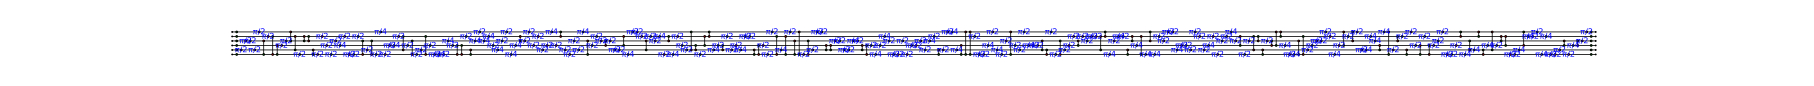

In [21]:
qubits = 6
depth = 300
#seed = 76072 # easier
seed = 33183
#depth = 60
#seed = 154
# qubits = 3
# depth = 30
# seed = 42950 #Exception on this one
random.seed(seed)
circ = zx.cliffordT(qubits, depth, p_t=0.2)
zx.draw(circ,figsize=(25,1))

No good cut for phase gadget found
No good cut for phase gadget found


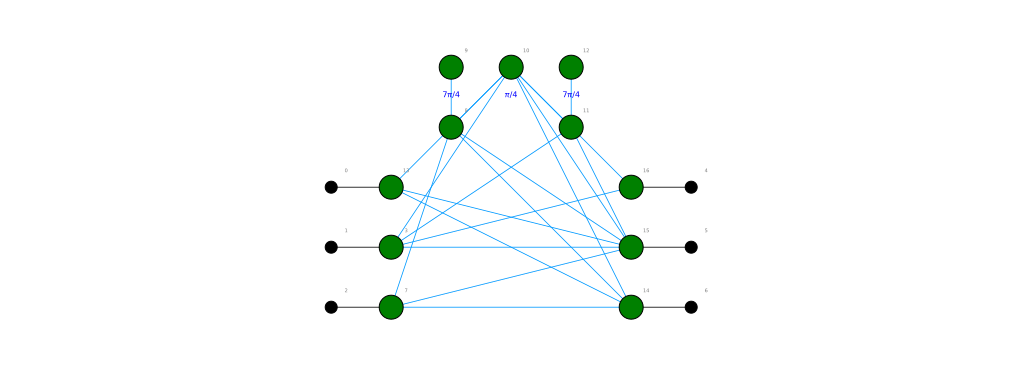

In [124]:
g = circ.copy()
full_reduce(g)
g.normalise()
try: c = zx.extract.streaming_extract(g,quiet=False)
except Exception as e: print(e)
zx.simplify.id_simp(g, quiet=True)
g.normalise()
g = g.adjoint()
try: c = zx.extract.streaming_extract(g,stopcount=-1).to_basic_gates()
except Exception as e: print(e)
zx.simplify.id_simp(g, quiet=True)
g.normalise()
g = g.adjoint()
#g2 = g.copy()
#g.set_phase(191,0)
#g.set_phase(193,0)
# g2.set_phase(9,0)
# # g2.set_qubit(12,-1.2)
# # g2.set_qubit(7,-1.2)
# g2.set_position(12,0,3)
# g2.set_position(15,1,3)
# g2.set_position(16,2,3)
# # g2.remove_vertices([5,6,2,7])
# g2.remove_edges([(5,9), (10,2), (10,5),(10,6)])
# g2.add_edges([(5,6)],2)
# g2.set_edge_type((10,3),2)
# g2.set_edge_type((2,4),2)
#g.set_row(182,3)
#g.set_row(183,3)
zx.draw(g, labels=True, figsize=(14,5))

In [167]:
cg = c.to_graph()
#cg.compose(g)
zx.compare_tensors(circ.to_tensor(), cg.to_tensor())

True

In [126]:
from pyzx.extract import cut_rank, cut_edges, bi_adj
from pyzx.circuit import Circuit, ParityPhase, CNOT, HAD, ZPhase, CZ

def connectivity_from_biadj(g, m, left, right, edgetype=2):
    for i in range(len(right)):
        for j in range(len(left)):
            if m.data[i][j] and not g.connected(right[i],left[j]):
                g.add_edge((right[i],left[j]),edgetype)
            elif not m.data[i][j] and g.connected(right[i],left[j]):
                g.remove_edge((right[i],left[j]))

def handle_phase_gadget(g, leftrow, has_reduced=False, quiet=True):
    #raise Exception("Stop here")
    q = g.qubit_count()
    qs = g.qubits() # We are assuming this thing automatically updates
    rs = g.rows()
    gates = []
    special_nodes = {}
    left = []
    for v in g.vertices():
        if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
            n = list(g.neighbours(v))[0]
            special_nodes[n] = v
        if rs[v] == leftrow: left.append(v)
    
    neigh = set()
    for v in left: neigh.update(w for w in g.neighbours(v) if rs[w]>leftrow)
    gadgets = neigh.intersection(special_nodes) # These are the phase gadgets that are attached to the left row
    if len(gadgets) == 0: raise ValueError("No phase gadget connected to this row")
    all_verts = neigh.union(left)
    for gadget in gadgets:
        n = neigh.difference({gadget})
        leftplusgadget = left + [gadget]
        n = n.union([w for w in g.neighbours(gadget) if w not in left])
        n = n.difference({special_nodes[gadget]})
        right = list(n)
        cr = cut_rank(g, right, leftplusgadget)
        if cr == q: # A good choice should allow us to cut the edges
            break
    else:
        for gadget in gadgets:
            n = set(g.neighbours(gadget))
            n.remove(special_nodes[gadget])
            gadget_right = n.difference(left)
            if len(gadget_right) < len(left) and all_verts.issuperset(n):
                # the gadget only has connections to left and neigh
                # and there aren't too many connections
                other_right = neigh.difference(gadget_right)
                other_right.remove(gadget)
                annoying_left = [v for v in left if any(g.connected(v,w) for w in other_right)]
                if len(gadget_right) + len(annoying_left) == len(left):
                    if not quiet: print("We have found a special match", gadget, annoying_left)
                    right = list(gadget_right)
                    for v in annoying_left:
                        v1 = g.add_vertex(1,qs[v], leftrow+2)
                        v2 = g.add_vertex(1,qs[v], leftrow+3)
                        g.add_edges([(v,v1),(v1,v2)],2)
                        for w in other_right:
                            if not g.connected(v,w): continue
                            e = g.edge(v,w)
                            et = g.edge_type(e)
                            g.remove_edge(e)
                            g.add_edge((v2,w),et)
                        right.append(v1)
                    break
        else:
            if not has_reduced:
                #print("Trying to reduce")
                left.sort(key=g.qubit)
                right = list(neigh.difference(gadgets))
                m = bi_adj(g, right, left)
                #print(m)
                gates = m.to_cnots()
                neigh = list(neigh)
                m = bi_adj(g, neigh, left)
                #print(m)
                for cnot in gates:
                    m.row_add(cnot.target, cnot.control)
                #print(m)
                connectivity_from_biadj(g, m, neigh, left)
                return gates, leftrow
                print("We must go deeper")
                gs, lr = handle_phase_gadget(g, leftrow, has_reduced=True, quiet=quiet)
                gates.extend(gs)
                return gates, lr
            else:
                raise ValueError("No good cut for phase gadget found")

    g.set_row(gadget,leftrow+1)
    g.set_row(special_nodes[gadget],leftrow+1)

    # Take care nothing is connected directly to an output
    for i in range(len(right)):
        w = right[i]
        if w in g.outputs:
            w2 = g.add_vertex(1, qs[w], rs[w]-1)
            n = list(g.neighbours(w))[0] # Outputs should have unique neighbours
            e = g.edge(n,w)
            et = g.edge_type(e)
            g.remove_edge(e)
            g.add_edge((n,w2),2)
            g.add_edge((w2,w),3-et)
            right[i] = w2

    if len(right) == q:
        if not quiet: print("No cutting necessary")
        for w in right:
            g.set_row(w, leftrow+2)
    else:
        right = cut_edges(g, left+[gadget], right)
    # We have now prepared the stage to do the extraction of the phase gadget
    
    phase = g.phase(special_nodes[gadget])
    phase = -1*phase if g.phase(gadget) != 0 else phase
    left.sort(key=g.qubit)
    right.sort(key=g.qubit)
    
    m = bi_adj(g, right, left)
    if m.rank() != q:
        raise Exception("Rank doesn't match, say whaat")
    operations = Circuit(q)
    operations.row_add = lambda r1,r2: operations.gates.append((r1,r2))
    m.gauss(full_reduce=True,x=operations)
    gates.extend([CNOT(r2,r1) for r1,r2 in operations.gates])
    m = bi_adj(g, right+[gadget], left)
    for r1,r2 in operations.gates:
        m.row_add(r1,r2)
    connectivity_from_biadj(g, m, right+[gadget], left)
    #return gates, leftrow
    gadget_left = [v for v in left if g.connected(gadget, v)]
    gadget_right = [w for w in right if g.connected(gadget, w)]
    targets = [qs[v] for v in gadget_left]
    # We bring as many connections on the right to the left
    for i in reversed(range(len(gadget_right))): # The following checks if every phase connected node is on the right
        w = gadget_right[i]
        v = next(v for v in left if g.connected(w,v))
        g.set_edge_type((v,w),1)
        g.set_qubit(w, qs[v])
        if qs[w] not in targets:
            gates.append(HAD(qs[w]))
            gadget_right.pop(i)
            targets.append(qs[w])
            gadget_left.append(v)
        else:
            g.set_row(w, leftrow+1)
    for w in right:
        if w in gadget_right: continue
        v = next(v for v in left if g.connected(w,v))
        g.set_qubit(w, qs[v])

    if not gadget_right: #Only connected on leftside so we are done
        if not quiet: print("Simple phase gadget")
        gate = ParityPhase(phase, *targets)
        g.remove_vertices([special_nodes[gadget],gadget])
        gates.append(gate)
        return gates, leftrow

    
    if not quiet: print("Complicated phase gadget") # targets on left and right, so need to do more
    if len(gadget_right) % 2 != 0 or len(gadget_left) == 1:
        raise Exception("Gadget seems non-unitary")
    
    #Now we can finally extract the phase gadget
    rtargets = []
    for w in gadget_right: 
        t = qs[w]
        rtargets.append(t)
        gates.extend([HAD(t),ZPhase(t,Fraction(-1,2)),HAD(t)])
    if len(gadget_right)%4 != 0: # This is either 2 or 0
        phase = (-phase)%2
    gates.append(ParityPhase(phase, *targets))
    for t in rtargets:
        gates.extend([HAD(t),ZPhase(t, Fraction(1,2))])
    for v in left:
        if qs[v] not in rtargets:
            g.set_row(v, leftrow+1)

    g.remove_vertices([special_nodes[gadget],gadget])
    if not quiet: print("end")
    return gates, leftrow+1

g2 = g.copy()
g3 = g2.copy()
#g3.add_edge((3,25),2)
gates, leftrow = handle_phase_gadget(g3, 1)
#g3.set_row(12,4)
#g3.set_row(11,4)
c = zx.Circuit(g.qubit_count())
c.gates = gates
c.add_gate("ZPhase",0,0)
c.add_gate("ZPhase",1,0)
c.add_gate("ZPhase",2,0)
cg = c.to_graph()
cg.compose(g3)

zx.compare_tensors(g.to_tensor(),cg.to_tensor())

8 3


True

In [91]:
gates

[CNOT(0,1),
 CNOT(1,0),
 CNOT(0,2),
 CNOT(1,2),
 ZPhase(0,phase=0),
 ZPhase(1,phase=0),
 ZPhase(2,phase=0)]

In [119]:
g = g3
leftrow = 1
q = g.qubit_count()
qs = g.qubits() # We are assuming this thing automatically updates
rs = g.rows()
special_nodes = {}
left = []
for v in g.vertices():
    if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
        n = list(g.neighbours(v))[0]
        special_nodes[n] = v
    if rs[v] == leftrow: left.append(v)

neigh = set()
for v in left: neigh.update(w for w in g.neighbours(v) if rs[w]>leftrow)
gadgets = neigh.intersection(special_nodes) # These are the phase gadgets that are attached to the left row

In [120]:
left.sort(key=g.qubit)
gadget = 8
right = list(neigh.difference({gadget}))
neigh = list(neigh)
m = bi_adj(g, neigh, left+[gadget])
#m.gauss(full_reduce=True)
print(m)

[ 1  0  1  0  1  1 ]
[ 1  1  0  0  0  0 ]
[ 1  0  0  1  1  0 ]
[ 0  1  0  1  1  0 ]


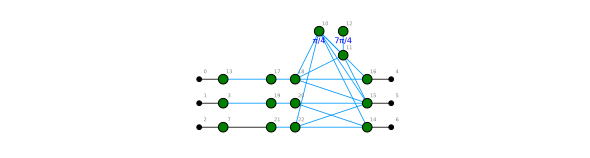

In [127]:
zx.draw(g3, labels=True)

In [103]:
for gadget in gadgets:
    g.set_type(gadget, 2)
    for e in g.incident_edges(gadget):
        g.set_edge_type(e,1)
js = zx.graph_to_json(g)
import os
path = r"C:\Users\John\Desktop\zx-project\graphs\pyzxgraph.qgraph"
f = open(path, 'w')
f.write(js)
f.close()

In [119]:
adj = g3.adjoint()
adj.compose(g3)
zx.compare_tensors(adj.to_tensor(),zx.generate.identity(g.qubit_count()).to_tensor())

True

In [75]:
t = g2.to_tensor()
t/t.flatten()[0]

array([[[[ 1.+0.j        , -0.+0.41421356j],
         [ 1.+0.j        , -0.+0.41421356j]],

        [[ 1.+0.j        ,  0.-0.41421356j],
         [-1.-0.j        , -0.+0.41421356j]]],


       [[[-0.+0.41421356j,  1.+0.j        ],
         [ 0.-0.41421356j, -1.-0.j        ]],

        [[ 0.-0.41421356j,  1.+0.j        ],
         [ 0.-0.41421356j,  1.+0.j        ]]]])

In [ ]:
def old_handle_phase_gadget(g, leftrow):
    q = g.qubit_count()
    qs = g.qubits() # We are assuming this thing automatically updates
    rs = g.rows()
    special_nodes = {}
    left = []
    for v in g.vertices():
        if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
            n = list(g.neighbours(v))[0]
            special_nodes[n] = v
        if rs[v] == leftrow: left.append(v)
    
    neigh = set()
    for v in left: neigh.update(w for w in g.neighbours(v) if rs[w]>leftrow)
    gadgets = neigh.intersection(special_nodes) # These are the phase gadgets that are attached to the left row
    if len(gadgets) == 0: raise ValueError("No phase gadget connected to this row")
    all_verts = neigh.union(left)
    for gadget in gadgets:
        #if not all_verts.issuperset(g.neighbours(gadget)): continue
        right = list(neigh.difference({gadget}).union(g.neighbours(gadget)))
        if cut_rank(g, right, left + [gadget]) == q: # A good choice should allow us to cut the edges
            break
    else:
        for gadget in gadgets:
            n = set(g.neighbours(gadget))
            n.remove(special_nodes[gadget])
            gadget_right = n.difference(left)
            if len(gadget_right) < len(left) and all_verts.issuperset(n):
                # the gadget only has connections to left and neigh
                # and there aren't too many connections
                other_right = neigh.difference(gadget_right)
                other_right.remove(gadget)
                annoying_left = [v for v in left if any(g.connected(v,w) for w in other_right)]
                if len(gadget_right) + len(annoying_left) == len(left):
                    print("We have found a special match", gadget, annoying_left)
                    right = list(gadget_right)
                    for v in annoying_left:
                        v1 = g.add_vertex(1,qs[v], leftrow+2)
                        v2 = g.add_vertex(1,qs[v], leftrow+3)
                        g.add_edges([(v,v1),(v1,v2)],2)
                        for w in other_right:
                            if not g.connected(v,w): continue
                            e = g.edge(v,w)
                            et = g.edge_type(e)
                            g.remove_edge(e)
                            g.add_edge((v2,w),et)
                        right.append(v1)
                    break
        else:
            raise ValueError("No good cut for phase gadget found")
    g.set_row(gadget,leftrow+1)
    g.set_row(special_nodes[gadget],leftrow+1)
    #return [], leftrow
    # Take care nothing is connected directly to an output
    for i in range(len(right)):
        w = right[i]
        if w in g.outputs:
            w2 = g.add_vertex(1, qs[w], rs[w]-1)
            n = list(g.neighbours(w))[0] # Outputs should have unique neighbours
            e = g.edge(n,w)
            et = g.edge_type(e)
            g.remove_edge(e)
            g.add_edge((n,w2),2)
            g.add_edge((w2,w),3-et)
            right[i] = w2
    if len(right) == q:
        print("No cutting necessary")
        for w in right:
            g.set_row(w, leftrow+2)
    else:
        right = cut_edges(g, left+[gadget], right)
    
    # We have now prepared the stage to do the extraction of the phase gadget
    phase = g.phase(special_nodes[gadget])
    phase = -1*phase if g.phase(gadget) != 0 else phase
    left.sort(key=g.qubit)
    right.sort(key=g.qubit)
    
    m = bi_adj(g, right, left)
    if m.rank() != q:
        raise Exception("Rank doesn't match, say whaat")
    operations = Circuit(q)
    operations.row_add = lambda r1,r2: operations.gates.append((r1,r2))
    m.gauss(full_reduce=True,x=operations)
    gates = [CNOT(r2,r1) for r1,r2 in operations.gates]
    m = bi_adj(g, right+[gadget], left)
    for r1,r2 in operations.gates:
        m.row_add(r1,r2)
    connectivity_from_biadj(g, m, right+[gadget], left)
    #return gates, leftrow
    gadget_left = [v for v in left if g.connected(gadget, v)]
    gadget_right = [w for w in right if g.connected(gadget, w)]
    targets = [qs[v] for v in gadget_left]
    # We bring as many connections on the right to the left
    for i in reversed(range(len(gadget_right))): # The following checks if every phase connected node is on the right
        w = gadget_right[i]
        v = next(v for v in left if g.connected(w,v))
        g.set_edge_type((v,w),1)
        g.set_qubit(w, qs[v])
        if qs[w] not in targets:
            gates.append(HAD(qs[w]))
            gadget_right.pop(i)
            targets.append(qs[w])
            gadget_left.append(v)
        else:
            g.set_row(w, leftrow+1)
    for w in right:
        if w in gadget_right: continue
        v = next(v for v in left if g.connected(w,v))
        g.set_qubit(w, qs[v])
    #return gates, leftrow
    #return gates, targets
        #if len(neigh) != 1 or neigh[0] in gadget_left or len([w2 for w2 in right if g.connected(w2,neigh[0])]) != 1:
        #    break
#     else:
#         print("Simple phase gadget up to hadamard")
#         for w in gadget_right:
#             gates.append(HAD(qs[w]))
#             v = next(v for v in left if g.connected(w,v))
#             g.set_edge_type((v,w),1)
#         gadget_left.extend(gadget_right)
#         gadget_right = []
#     marked_qubits = []
#     if gadget_left: # The same but for the lefthandside
#         for v in gadget_left: 
#             neigh = [w for w in right if g.connected(w,v)]
#             if len(neigh) != 1 or neigh[0] in gadget_right: break
#             n = neigh[0]
#             if len([v2 for v2 in left if g.connected(v2,n)]) != 1 or len(list(g.neighbours(n))) != 2: break
#         else:
#             print("Simple phase gadget up to hadamard")
#             displaced_verts = set()
#             locations = set()
#             for v in gadget_left:
#                 w = next(w for w in right if g.connected(v,w))
#                 if qs[w] != qs[v]: # We need to move w to the qubit position of v
#                     if qs[v] in locations:
#                         locations.remove(qs[v])
#                     else:
#                         w2 = right[qs[v]] # the vertex that is in the way
#                         displaced_verts.add(w2)
#                     locations.add(qs[w])
#                     g.set_qubit(w, qs[v])
#                 g.set_edge_type((v,w),1)
#                 n = next(n for n in g.neighbours(w) if n!=v) # The unique other neighbour of w
#                 g.set_edge_type((w,n),1)
#                 marked_qubits.append(qs[v])
#             for w in displaced_verts: # Move vertices whose qubit location was dibsed to other location
#                 g.set_qubit(w, locations.pop())
#             right.sort(key=g.qubit)
#             gadget_right.extend(gadget_left)
#             gadget_left = []
    if not gadget_right: #Only connected on leftside so we are done
        print("Simple phase gadget")
        gate = ParityPhase(phase, *targets)
        g.remove_vertices([special_nodes[gadget],gadget])
        gates.append(gate)
        return gates, leftrow
#         m = bi_adj(g, right, left) # ParityPhase on the right side, which means we have to 
#         rightgates = m.to_cnots(optimize=True) # reduce everything before it to cnots
#         gates.extend(rightgates)
#         for t in range(q):
#             if t in marked_qubits: continue
#             gates.append(HAD(t))
#         gates.append(gate)
#         for i in range(q):
#             for j in range(q):
#                 if i ==j:
#                     if not g.connected(left[i], right[j]):
#                         g.add_edge((left[i],right[j]), 1)
#                 else:
#                     if g.connected(left[i],right[j]):
#                         g.remove_edge((left[i],right[j]))
#         return gates, leftrow+2

    
    print("Complicated phase gadget") # targets on left and right, so need to do more preparation
    if len(gadget_right) % 2 != 0 or len(gadget_left) == 1:
        raise Exception("Gadget seems non-unitary")
    #raise Exception("Stop here")
#     gates = []
#     m = bi_adj(g, right, left)
    #return gates, leftrow
#     left_options = [v for v in left if any(g.connected(v,w) for w in gadget_right)]
#     print("left_options", left_options)
#     if len(gadget_left) > 2:
#         raise Exception("Too many on the left. Not supported yet")
#     if len(gadget_left) == 1: # We need additional connectivity
#         v1 = gadget_left[0]
#         options = set(left_options).difference({v1})
#         if not options:
#             raise Exception("Not supported yet")
#         v2 = options.pop()
#         gates.append(CNOT(qs[v2],qs[v1]))
#         m.row_add(qs[v1],qs[v2])
#         g.add_edge((v2,gadget),2)
#         #print(m,'.')
#         gadget_left.append(v2)
#         connectivity_from_biadj(g, m, right, left)
    
    #return gates, leftrow
    
#     m = bi_adj(g, gadget_left, right)
#     operations = Circuit(q)
#     operations.row_add = lambda r1,r2: operations.gates.append((r1,r2))
#     m.gauss(full_reduce=True,x=operations)
#     gatesright = [CNOT(r2,r1) for r1,r2 in operations.gates]
#     leftwithgadget = left + [gadget]
#     m = bi_adj(g, right, leftwithgadget)
#     for cnot in gatesright:
#         m.col_add(cnot.target,cnot.control)
#     connectivity_from_biadj(g, m, right, leftwithgadget)
#     #return gates, gatesright
#     displaced_verts = set()
#     moved = set()
#     locations = set()
#     relabeling = {i:i for i in range(q)}
#     for v in gadget_left:
#         if sum(m.data[qs[v]]) != 1:
#             raise Exception("Not fully reduced on vertex ", v)
#         w = next(w for w in right if g.connected(v,w))
#         if qs[w] != qs[v]: # We need to move w to the qubit position of v
#             if qs[v] in locations:
#                 locations.remove(qs[v])
#             else:
#                 w2 = right[qs[v]] # the vertex that is in the way
#                 if w2 not in moved:
#                     displaced_verts.add(w2)
#             if w not in displaced_verts: locations.add(qs[w])
#             relabeling[qs[w]] = qs[v]
#             moved.add(w)
#             g.set_qubit(w, qs[v])
#         #g.set_edge_type((v,w),1)
#     for w in displaced_verts.difference(moved): # Move vertices whose qubit location was dibsed to other location
#         l = locations.pop()
#         relabeling[qs[w]] = l
#         g.set_qubit(w, l)
#     for gate in gatesright:
#         gate.target = relabeling[gate.target]
#         gate.control = relabeling[gate.control]
#     right.sort(key=g.qubit)
#     m = bi_adj(g, right, leftwithgadget)
#     #return gates, gatesright
#     gadget_right = [w for j,w in enumerate(right) if m.data[-1][j]]
#     gadgetr_qs = {qs[w] for w in gadget_right}
#     gadgetl_qs = {qs[v] for v in gadget_left}
#     add_gadgets = gadgetl_qs.difference(gadgetr_qs)
#     remove_gadgets = gadgetr_qs.difference(gadgetl_qs)
#     if add_gadgets and not remove_gadgets:
#         raise Exception("Can't get phase gadget to norm form. Don't know how to continue")
#     if add_gadgets:
#         print("Adding gadgets")
#         r1 = list(remove_gadgets)[0]
#         for r2 in add_gadgets:
#             m.col_add(r1,r2)
#             gatesright.append(CNOT(r2,r1))
#             gadgetr_qs.add(r2)
#     if remove_gadgets:
#         print("Removing gadgets")
#         r1 = list(gadgetr_qs)[0]
#         for r2 in remove_gadgets:
#             m.col_add(r1,r2)
#             gatesright.append(CNOT(r2,r1))
#             gadgetr_qs.remove(r2)
#     connectivity_from_biadj(g, m, right, leftwithgadget)
#     for v in gadget_left:
#         w = next(w for w in right if g.connected(v,w))
#         g.set_edge_type(g.edge(v,w),1)
    #return gates, leftrow
    
#     right_options = [w for w in right if any(g.connected(w,v) for v in gadget_left)]
#     gatesright = []
#     if len(gadget_right) > 2:
#         raise Exception("Too many on the right. Not supported yet")
#     if len(gadget_right) == 1:
#         w1 = gadget_right[0]
#         options = set(right_options).difference({w1})
#         if not options:
#             raise Exception("Not supported yet")
#         w2 = options.pop()
#         gatesright.append(CNOT(qs[w2],qs[w1])) # This gate needs to come after all the other gates we extracct
#         m.col_add(qs[w1],qs[w2])
#         g.add_edge((w2,gadget),2)
#         gadget_right.append(w2)
#         #print(m)
        
#     for i in range(q):
#         for j in range(q):
#             if m.data[i][j] and not g.connected(left[i],right[j]):
#                 g.add_edge((left[i],right[j]),2)
#             elif not m.data[i][j] and g.connected(left[i],right[j]):
#                 g.remove_edge((left[i],right[j]))
    
    # We now need to move the vertices on the right that are connected to
    # the phase gadget to the corresponding qubits of the left side
#     displaced_verts = set()
#     locations = set()
#     for v in gadget_left:
#         if sum(m.data[qs[v]]) != 1:
#             raise Exception("Not fully reduced on vertex ", v)
#         w = next(w for w in gadget_right if g.connected(v,w))
#         if qs[w] != qs[v]: # We need to move w to the qubit position of v
#             if qs[v] in locations:
#                 locations.remove(qs[v])
#             else:
#                 w2 = right[qs[v]] # the vertex that is in the way
#                 if w2 not in gadget_right:
#                     displaced_verts.add(w2)
#             locations.add(qs[w])
#             g.set_qubit(w, qs[v])
#         g.set_edge_type((v,w),1)
#     for w in displaced_verts: # Move vertices whose qubit location was dibsed to other location
#         g.set_qubit(w, locations.pop())
    
    #Now we can finally extract the phase gadget
    #return gates,gatesright
    
    #targets = [qs[v] for v in gadget_left]
    rtargets = []
    for w in gadget_right: 
        t = qs[w]
        rtargets.append(t)
        gates.extend([HAD(t),ZPhase(t,Fraction(-1,2)),HAD(t)])
    if len(gadget_right)%4 != 0: # This is either 2 or 0
        phase = (-phase)%2
    gates.append(ParityPhase(phase, *targets))
    for t in rtargets:
        gates.extend([HAD(t),ZPhase(t, Fraction(1,2))])
    for v in left:
        if qs[v] not in rtargets:
            g.set_row(v, leftrow+1)
    #for gate in gatesright: # And finally we can add the gates on the rightside, taking care to change their qubit locations
#         gate.target = qs[right[gate.target]]
#         gate.control = qs[right[gate.control]]
    #    gates.append(gate)
    # There might be some connectivity between things on the left and on the right that we
    # need to take care of
    #for w in gadget_right:
    #    g.set_row(w, leftrow+1)
#         conn = [v for v in left if v not in gadget_left and g.connected(v,w)]
#         for v in conn:
#             gates.append(CZ(qs[w], qs[v]))
#         g.remove_edges([(v,w) for v in conn])
    #return gates, leftrow
    g.remove_vertices([special_nodes[gadget],gadget])
    print("end")
    return gates, leftrow+1

In [77]:
def paccept(r):
    return (random.random() < r)

def circuit_generator(g, limit=6):
    t = g.to_tensor()
    q = g.qubit_count()
    while True:
        c = zx.Circuit(q)
        amount = random.randint(2, limit)
        for g in range(amount):
            target = random.randint(0,q-1)
            
            if paccept(0.2):
                denom = 2**random.randint(0,1)
                numer = random.randint(1,2*denom-1)
                if paccept(0.5): c.add_gate("ZPhase", target, Fraction(numer,denom))
                else: c.add_gate("XPhase", target, Fraction(numer,denom))
            elif paccept(0.2):
                c.add_gate("HAD",target)
            else:
                control = random.randint(0,q-1)
                while control == target: control = random.randint(0,q-1)
                if paccept(0.5):
                    c.add_gate("CNOT", control, target)
                else:
                    numer = 1 + 2*random.randint(0,3)
                    c.add_gate("ParityPhase", Fraction(numer,4), control, target)
        if zx.compare_tensors(c.to_tensor(), t):
            return c

c = circuit_generator(g2,6)
zx.draw(c.to_graph())

KeyboardInterrupt: 

In [188]:
g = g2.copy()
from pyzx.extract import bi_adj, cut_rank
rs = g.rows()
q = g.qubit_count()
leftrow = 1
left = [v for v in g.vertices() if rs[v] == leftrow]
left.sort(key=g.qubit)
right = set()
for v in left:
    d = [w for w in g.neighbours(v) if rs[w]>leftrow]
    right.update(d)

special_nodes = {}
for v in g.vertices():
    if len(list(g.neighbours(v))) == 1 and v not in g.inputs and v not in g.outputs:
        n = list(g.neighbours(v))[0]
        special_nodes[n] = v
#right.difference_update(special_nodes)
#right = list(right)
for w in right:
    other = right.difference([w])
    if cut_rank(g, other, left) == q-1:
        break
    print(w, cut_rank(g, other,left))
else:
    print("Error")
# import random
# while True:
#     selection = random.sample(right, q)
#     m = bi_adj(g,selection,left)
#     if m.rank() == q:
#         break
# other = right.difference(selection)
#m = bi_adj(g,right,left)
#cut_rank(g,right, left)

10 3
5 3
6 3
7 3
Error


In [187]:
left, right, w, other

([3, 12, 4], {5, 6, 7}, 5, {6, 7})

In [52]:
from pyzx.extract import cut_edges, unspider
#g2 = g
#g = g.copy()
available = list(range(q))
for v in left:
    if g.connected(v,w):
        g.set_qubit(w, g.qubit(v))
        available.remove(g.qubit(v))
        break
cut_edges(g, left, list(other), available)
g.set_row(w, leftrow+2)
unspider(g,w)

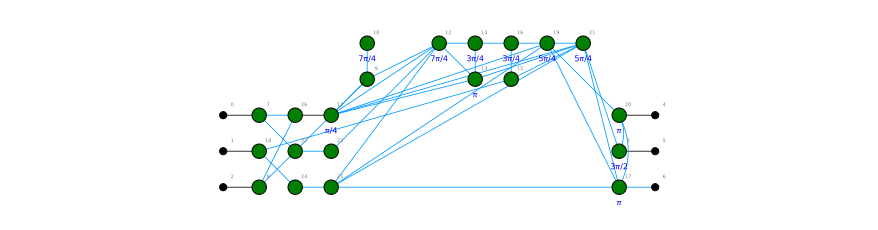

In [53]:
zx.draw(g,labels=True,figsize=(12,3))

In [54]:
right = set()
for v in left:
    d = [w for w in g.neighbours(v) if rs[w]>leftrow]
    right.update(d)
right = list(right)
m = bi_adj(g, right, left)
m, left, right

([ 0  0  1  1  0 ]
 [ 1  0  0  0  1 ]
 [ 0  1  1  0  0 ], [7, 18, 8], [24, 9, 26, 22, 15])

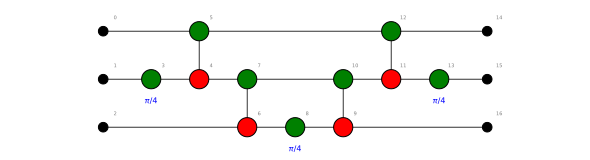

In [135]:
c = zx.Circuit(3)
c.add_gate("T",1)
c.add_gate("ParityPhase",Fraction(1,4),0,1,2)
# c.add_gate("CNOT",0,1)
# c.add_gate("T",1)
# c.add_gate("CNOT",0,1)
c.add_gate("T",1)
g = c.to_graph()
zx.draw(g,labels=True)

spider_simp: 1.  1 iterations
Gadgetizing...
pivot_simp: 2. 1.  2 iterations
pivot_simp: 1.  1 iterations
id_simp: 3.  1 iterations
spider_simp: 1.  1 iterations
1


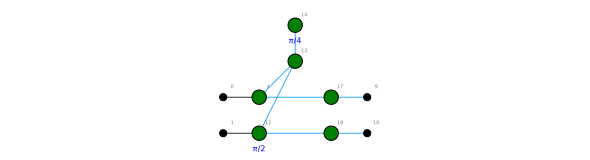

In [8]:
g = c.to_graph()
full_reduce(g,quiet=False)
print(tcount(g))
# for v in g.vertices():
#     q = g.qubit(v)
#     if q < 0: 
#         g.set_qubit(v, -q-1)
#         g.set_row(v, g.row(v)+0.5)
g.normalise()

zx.draw(g,labels=True)

In [9]:
c2 = zx.extract.streaming_extract(g).to_basic_gates()
print(c2.gates)

[ZPhase(1,phase=1/2), CNOT(1,0), ZPhase(0,phase=1/4), CNOT(1,0), HAD(0), HAD(1), HAD(0), HAD(1)]


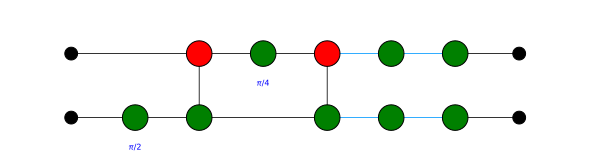

In [10]:
zx.draw(c2.to_graph())

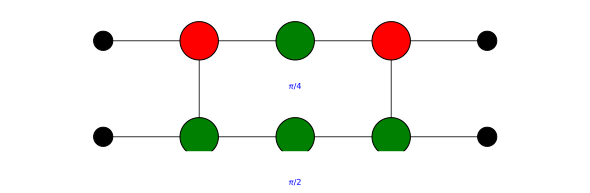

In [13]:
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c2)
zx.draw(c3.to_graph())

In [44]:
while True:
    edges = [e for e in g.edges() if e not in es]
    print(edges)
    m = zx.rules.match_pivot_parallel(g, check_edge_types=True,edgelist=edges)
    if not m: break
    etab, rem_verts, rem_edges, check_isolated_vertices = zx.rules.pivot(g, m)
    g.add_edge_table(etab)
    g.remove_edges(rem_edges)
    g.remove_vertices(rem_verts)
    if check_isolated_vertices: g.remove_isolated_vertices()
zx.simplify.id_simp(g,quiet=True)
zx.simplify.spider_simp(g,quiet=True)
zx.simplify.id_simp(g,quiet=True)
g.normalise()
zx.draw(g)

NameError: name 'es' is not defined

In [3]:
def gadgetize(g):
    phases = g.phases()
    #qs = g.qubits()
    rs = g.rows()
    edges = []
    for v in list(g.vertices()):
        if phases[v] != 0 and phases[v].denominator > 2:
            v1 = g.add_vertex(1,-1,rs[v]+0.5,0)
            v2 = g.add_vertex(1,-2,rs[v]+0.5,phases[v])
            g.set_phase(v, 0)
            edges.append((v,v1))
            edges.append((v1,v2))
    g.add_edges(edges, 2)
    return edges

In [4]:
def full_reduce(g, quiet=True):
    zx.simplify.clifford_simp(g,quiet=quiet)
    if not quiet: print("Gadgetizing...")
    es = gadgetize(g)
    edges = [e for e in g.edges() if e not in es]
    zx.simplify.pivot_simp(g,matchset=edges,quiet=quiet)
    zx.simplify.lcomp_simp(g, quiet=quiet)
    edges = [e for e in g.edges() if e not in es]
    zx.simplify.pivot_simp(g,matchset=edges,quiet=quiet)
    phases = g.phases()
    for v in g.vertices():
        if phases[v] != 0 and phases[v].denominator > 2 and len(list(g.neighbours(v)))==1:
            n = list(g.neighbours(v))[0]
            if phases[n] == 1:
                g.set_phase(n, 0)
                g.set_phase(v, -1*phases[v])
                phases[n] = 0
    zx.simplify.clifford_simp(g,quiet=quiet)

In [5]:
def tcount(g):
    count = 0
    phases = g.phases()
    for v in g.vertices():
        if phases[v]!=0 and phases[v].denominator > 2:
            count += 1
    return count

In [93]:
import os
f = os.path.abspath("../circuits/Arithmetic_and_Toffoli/barenco_tof_3_before")
c = zx.Circuit.from_quipper_file(f)
g = c.to_graph()
full_reduce(g,quiet=False)
g.normalise()
#zx.draw(g, figsize=(25,4))
#zx.simplify.clifford_simp(g)
print(tcount(g))
#g.normalise()
#zx.draw(g)
c2 = zx.extract.streaming_extract(g)
print(len(c2.gates))
g = c2.to_graph()
zx.simplify.to_gh(g)
zx.simplify.id_simp(g,quiet=True)
c3 = zx.Circuit.from_graph(g, split_phases=False)
print(len(c3.gates))
import pyzx.phasepoly
c3, par = pyzx.phasepoly.circuit_phase_polynomial_blocks(c3, optimize=True)
print(c3.stats())

spider_simp: 10. 8. 4. 2. 2. 1.  6 iterations
spider_simp: 2.  1 iterations
pivot_simp: 7.  1 iterations
id_simp: 2.  1 iterations
Gadgetizing...
pivot_simp: 12. 5. 1. 1.  4 iterations
pivot_simp: 4. 1. 2.  3 iterations
pivot_simp: 1.  1 iterations
id_simp: 5.  1 iterations
spider_simp: 1. 1.  2 iterations
20
50
136
Circuit on 5 qubits with 62 gates.
        18 T-like gates
        44 Cliffords among which 
        29 2-qubit gates and 10 Hadamard gates.


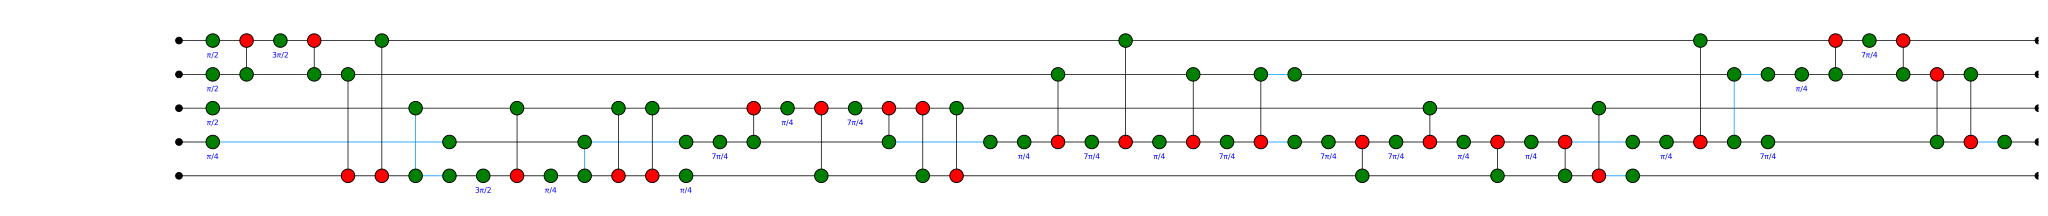

In [94]:
zx.draw(c3.to_graph(), figsize=(30,3))

In [95]:
zx.compare_tensors(c3.to_tensor(),c.to_tensor())

True